# Notebook objectives
- Understand COCO dataset structure from OD perspective
- Transforms used for OD in DETR
- COCO Dataset torch class - Image, target definition
- Visualize sample images with bounding boxes
- Dataloader collate function

## Imports

In [1]:
import os
import sys
import json
import numpy as np
from pathlib import Path
from typing import Dict, List, Optional

# add scripts directory
sys.path.append(os.path.join(os.getcwd(), *['..', 'scripts']))

In [2]:
"""
COCO dataset which returns image_id for evaluation.
Mostly copy-paste from https://github.com/pytorch/vision/blob/13b35ff/references/detection/coco_utils.py
"""

# torch imports
import torch
import torchvision
import torch.utils.data
from torchvision import transforms
import torchvision.transforms.functional as F

# transforms related imports
import transforms as T
from pycocotools import mask as coco_mask

# plotting imports
import matplotlib.pyplot as plt
plt.rcParams["savefig.bbox"] = 'tight'
from box_ops import box_cxcywh_to_xyxy
from matplotlib import patches, text, patheffects

## Constants

In [3]:
COCO_PATH = '/home/surya/Downloads/coco/'

## COCO Object Detection Dataset

### Understand COCO dataset structure

**Folder Structure**
- train2017/
    - <train_img1.jpg>
    - <train_img2.jpg>
    - <train_img3.jpg>    
    - ...
- val2017/
    - <val_img1.jpg>
    - <val_img2.jpg>
    - <val_img3.jpg>    
    - ...    
- annotations/
    - instances_train2017.json
    - instances_val2017.json

- There are about 118k training images, 5k validation images
- No fixed size for the image.
- 80 classes in total (but max class id is 91)
- instances_train2017.json, instances_val2017.json contain meta data about each image, ground truth bounding boxes and instance segmentation

In [4]:
train_annotations_path = os.path.join(COCO_PATH, *['annotations', 'instances_train2017.json'])
with open(train_annotations_path, 'r') as infile:
    train_annotations = json.load(infile)
    
print(f"train_annotations is of type {type(train_annotations)} and has following keys:\n {train_annotations.keys()}")

train_annotations is of type <class 'dict'> and has following keys:
 dict_keys(['info', 'licenses', 'images', 'annotations', 'categories'])


In [5]:
sample_idx = np.random.randint(0, len(train_annotations['images']))
for k in ['images', 'annotations']:
    print(f"{k}\n {train_annotations[k][sample_idx]}\n---------")

images
 {'license': 3, 'file_name': '000000543985.jpg', 'coco_url': 'http://images.cocodataset.org/train2017/000000543985.jpg', 'height': 500, 'width': 361, 'date_captured': '2013-11-17 10:25:18', 'flickr_url': 'http://farm1.staticflickr.com/7/9503645_a045184e9f_z.jpg', 'id': 543985}
---------
annotations
 {'segmentation': [[190.71, 286.71, 189.24, 318.25, 197.12, 320.71, 188.25, 331.55, 193.18, 345.84, 203.53, 344.86, 269.06, 336.48, 267.09, 333.03, 267.59, 329.09, 228.66, 279.81, 218.8, 278.33, 216.34, 273.9, 192.19, 285.23], [236.05, 268.97, 263.64, 267.49, 271.03, 275.38, 269.06, 315.78, 234.57, 273.9, 235.06, 270.45]], 'area': 4741.123549999998, 'iscrowd': 0, 'image_id': 183620, 'bbox': [188.25, 267.49, 82.78, 78.35], 'category_id': 72, 'id': 124654}
---------


In [6]:
coco_categories = train_annotations['categories']
print(f"There are {len(coco_categories)} categories in COCO dataset")
print(f"Sample entries:\n-----\n{coco_categories[0:5]}")

There are 80 categories in COCO dataset
Sample entries:
-----
[{'supercategory': 'person', 'id': 1, 'name': 'person'}, {'supercategory': 'vehicle', 'id': 2, 'name': 'bicycle'}, {'supercategory': 'vehicle', 'id': 3, 'name': 'car'}, {'supercategory': 'vehicle', 'id': 4, 'name': 'motorcycle'}, {'supercategory': 'vehicle', 'id': 5, 'name': 'airplane'}]


In [7]:
del train_annotations # deleting annotations it consumes lot of RAM

In [8]:
# class id to name mapping
cocoIdToClassMap = dict([(x['id'], x['name']) for x in coco_categories])

### Torch dataset

We'll define a torch Dataset based class, which can give instances of images, target annotations 

In [9]:
class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, ann_file, transforms, return_masks):
        super(CocoDetection, self).__init__(img_folder, ann_file)
        self._transforms = transforms
        self.prepare = ConvertCocoPolysToMask(return_masks)

    def __getitem__(self, idx):
        img, target = super(CocoDetection, self).__getitem__(idx)
        image_id = self.ids[idx]
        target = {'image_id': image_id, 'annotations': target}
        img, target = self.prepare(img, target)
        if self._transforms is not None:
            img, target = self._transforms(img, target)
        return img, target


def convert_coco_poly_to_mask(segmentations, height, width):
    masks = []
    for polygons in segmentations:
        rles = coco_mask.frPyObjects(polygons, height, width)
        mask = coco_mask.decode(rles)
        if len(mask.shape) < 3:
            mask = mask[..., None]
        mask = torch.as_tensor(mask, dtype=torch.uint8)
        mask = mask.any(dim=2)
        masks.append(mask)
    if masks:
        masks = torch.stack(masks, dim=0)
    else:
        masks = torch.zeros((0, height, width), dtype=torch.uint8)
    return masks


class ConvertCocoPolysToMask(object):
    def __init__(self, return_masks=False):
        self.return_masks = return_masks

    def __call__(self, image, target):
        w, h = image.size

        image_id = target["image_id"]
        image_id = torch.tensor([image_id])

        anno = target["annotations"]

        anno = [obj for obj in anno if 'iscrowd' not in obj or obj['iscrowd'] == 0]

        boxes = [obj["bbox"] for obj in anno]
        # guard against no boxes via resizing
        boxes = torch.as_tensor(boxes, dtype=torch.float32).reshape(-1, 4)
        boxes[:, 2:] += boxes[:, :2]
        boxes[:, 0::2].clamp_(min=0, max=w)
        boxes[:, 1::2].clamp_(min=0, max=h)

        classes = [obj["category_id"] for obj in anno]
        classes = torch.tensor(classes, dtype=torch.int64)

        if self.return_masks:
            segmentations = [obj["segmentation"] for obj in anno]
            masks = convert_coco_poly_to_mask(segmentations, h, w)

        keypoints = None
        if anno and "keypoints" in anno[0]:
            keypoints = [obj["keypoints"] for obj in anno]
            keypoints = torch.as_tensor(keypoints, dtype=torch.float32)
            num_keypoints = keypoints.shape[0]
            if num_keypoints:
                keypoints = keypoints.view(num_keypoints, -1, 3)

        keep = (boxes[:, 3] > boxes[:, 1]) & (boxes[:, 2] > boxes[:, 0])
        boxes = boxes[keep]
        classes = classes[keep]
        if self.return_masks:
            masks = masks[keep]
        if keypoints is not None:
            keypoints = keypoints[keep]

        target = {}
        target["boxes"] = boxes
        target["labels"] = classes
        if self.return_masks:
            target["masks"] = masks
        target["image_id"] = image_id
        if keypoints is not None:
            target["keypoints"] = keypoints

        # for conversion to coco api
        area = torch.tensor([obj["area"] for obj in anno])
        iscrowd = torch.tensor([obj["iscrowd"] if "iscrowd" in obj else 0 for obj in anno])
        target["area"] = area[keep]
        target["iscrowd"] = iscrowd[keep]

        target["orig_size"] = torch.as_tensor([int(h), int(w)])
        target["size"] = torch.as_tensor([int(h), int(w)])

        return image, target

Before we create the dataset, we'll define the Data augmentations for Object detection. The DA is kept simple as follows:
- Horizontal Flip
- Random Resize crop
- Normalize (using Imagenet mean, std.dev)
- Conversion to torch Tensor

**NOTE**: We'll need to modify the target annotations accordingly

### Transforms for Object detection

In [10]:
def make_coco_transforms(image_set):
    normalize = T.Compose([
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    scales = [480, 512, 544, 576, 608, 640, 672, 704, 736, 768, 800]
    if image_set == 'train':
        return T.Compose([
            T.RandomHorizontalFlip(),
            T.RandomSelect(
                T.RandomResize(scales, max_size=1333),
                T.Compose([
                    T.RandomResize([400, 500, 600]),
                    T.RandomSizeCrop(384, 600),
                    T.RandomResize(scales, max_size=1333),
                ])
            ),
            normalize,
        ])

    if image_set == 'val':
        return T.Compose([
            T.RandomResize([800], max_size=1333),
            normalize,
        ])

    raise ValueError(f'unknown {image_set}')


In [11]:
train_transforms = make_coco_transforms('train')
val_transforms = make_coco_transforms('val')
print(f"train_transforms = \n{train_transforms}")
print(f"val_transforms = \n{val_transforms}")

train_transforms = 
Compose(
    Compose(
)
)
val_transforms = 
Compose(
    Compose(
)
)


In [12]:
root = Path(COCO_PATH)
assert root.exists(), f'provided COCO path {root} does not exist'

mode = 'instances'
PATHS = {
    "train": (root / "train2017", root / "annotations" / f'{mode}_train2017.json'),
    "val": (root / "val2017", root / "annotations" / f'{mode}_val2017.json'),
}

img_folder, ann_file = PATHS['train']
dataset = CocoDetection(img_folder, ann_file, transforms=train_transforms, return_masks=False)

loading annotations into memory...
Done (t=12.84s)
creating index...
index created!


We'll look in sample images, data within targets from the training set

In [13]:
sample_image, sample_target = dataset[0]

# image info
print(f"Sample image type = {type(sample_image)}, shape = {sample_image.shape}")

# target info
print(f"Sample target type = {type(sample_target)}")
for (k,v) in sample_target.items():
    print(f"{k} has shape {v.shape}, contents = \n{v}\n-----")

Sample image type = <class 'torch.Tensor'>, shape = torch.Size([3, 544, 725])
Sample target type = <class 'dict'>
boxes has shape torch.Size([8, 4]), contents = 
tensor([[0.4795, 0.6888, 0.9556, 0.5955],
        [0.7365, 0.2472, 0.4989, 0.4764],
        [0.6371, 0.7329, 0.4941, 0.5106],
        [0.3394, 0.4189, 0.6789, 0.7815],
        [0.6468, 0.1326, 0.1180, 0.0969],
        [0.7731, 0.1298, 0.0907, 0.0972],
        [0.6683, 0.2269, 0.1313, 0.1469],
        [0.6429, 0.0792, 0.1481, 0.1481]])
-----
labels has shape torch.Size([8]), contents = 
tensor([51, 51, 56, 51, 55, 55, 55, 55])
-----
image_id has shape torch.Size([1]), contents = 
tensor([9])
-----
area has shape torch.Size([8]), contents = 
tensor([154135.8594,  57047.7383,  63650.8516,  31188.3867,   2874.9248,
          2129.7744,   4633.8184,   3819.8203])
-----
iscrowd has shape torch.Size([8]), contents = 
tensor([0, 0, 0, 0, 0, 0, 0, 0])
-----
orig_size has shape torch.Size([2]), contents = 
tensor([480, 640])
-----
size 

### Visualize Targets

We'll define some functions to visualise the images and bounding boxes

In [14]:
inverse_transform = transforms.Compose([
        transforms.Normalize((-0.485/0.229, -0.456/0.224, -0.406/0.225), (1/0.229, 1/0.224, 1/0.225))
    ])

def tensorToNumpy(data : torch.Tensor) -> np.ndarray:
    return data.detach().cpu().numpy()

def denormalize(data : torch.Tensor) -> np.ndarray:
    # reverse imagenet mean, std.dev
    return tensorToNumpy(inverse_transform(data).permute(1, 2, 0))

def scaleBBoxes(bboxes, width, height):
    return bboxes * torch.tensor([width, height, width, height], dtype=torch.float64)

def handlBBoxes(bboxes : torch.Tensor, width, height) -> np.ndarray:
    return tensorToNumpy((scaleBBoxes(bboxes, width, height)))

def getLowerBottomCorner(cx, cy, w, h):    
    return (cx - w * 0.5, cy - h * 0.5)

def plotBoundingBoxes(images, bboxes, labels):
    fig, axes = plt.subplots(figsize = (6, 6 * len(images)), nrows=len(images))
    if(len(images) > 1):
        axes = axes.flatten()
    else:
        axes = [axes]
    
    for (ax, image,bbox,label) in zip(axes, images, bboxes, labels):
        ax.imshow(image)
        for i in range(bbox.shape[0]):
            cx, cy, w, h = bbox[i]
            xmin, ymin = getLowerBottomCorner(cx, cy, w, h) 
            ax.add_patch(patches.Rectangle((xmin, ymin), w, h, fill=False, edgecolor='red', lw=1))
            ax.text(xmin,(ymin-50), str(label[i]), 
                    verticalalignment='top',color='white',fontsize=10,weight='bold')

In [20]:
NUM_SAMPLES = 1
sample_indices = np.random.randint(0, len(dataset), size =NUM_SAMPLES)

images = []
bboxes = []
labels = []
targets = []

for idx in sample_indices:
    image, target = dataset[idx]
    targets.append(target)
    h, w = target['size'][0], target['size'][1]
    images.append(denormalize(image))
    bboxes.append(handlBBoxes(target['boxes'], width=w, height=h))
    labels.append([cocoIdToClassMap[x] for x in tensorToNumpy(target['labels'])])

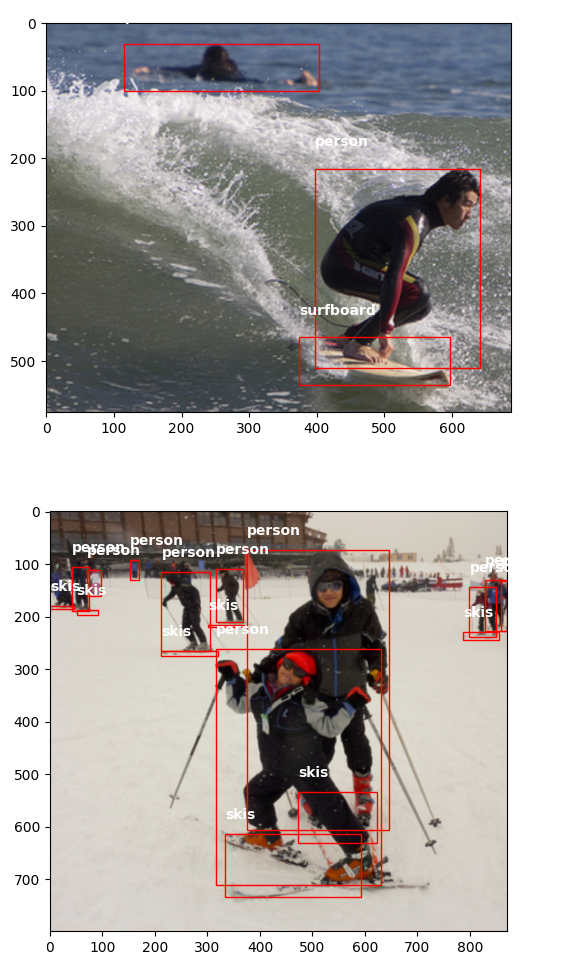

In [21]:
plotBoundingBoxes(images, bboxes, labels)

### Collate function

As each image is of different size, we need to figure out a way to common tensor size for all images in a batch. Common method is to padd all images in a batch to maximum size within batch. (i.e)
- Calculate the max size within a batch (height, width). Channels are usually same.
- Create a zero's tensor of shape (batch_size, n_channels, max_h, max_w)
- Iterate through each image in batch, fill images in top left corner
- We'll have a `mask` tensor to keep track of the padded pixels

First, we'll create a class to keep track of the tensor and associated mask

In [18]:
class NestedTensor(object):
    def __init__(self, tensors, mask: Optional[torch.Tensor]):
        self.tensors = tensors
        self.mask = mask

    def to(self, device):
        cast_tensor = self.tensors.to(device)
        mask = self.mask
        if mask is not None:
            assert mask is not None
            cast_mask = mask.to(device)
        else:
            cast_mask = None
        return NestedTensor(cast_tensor, cast_mask)

    def decompose(self):
        return self.tensors, self.mask

    def __repr__(self):
        return str(self.tensors)

In [26]:
sample_indices = np.random.randint(0, len(dataset), size =2)

images = []
targets = []

for i in sample_indices:
    image, target = dataset[i]
    images.append(image)
    targets.append(target)

We'll use the images, targets object to create a batch data

In [27]:
print(f"images has {len(images)} elements, of shapes {[x.shape for x in images]}")

images has 2 elements, of shapes [torch.Size([3, 926, 800]), torch.Size([3, 480, 480])]


In [34]:
# [(image1, target1, ...), (image2, target2, ...)]
batch = [(img,tgt) for (img,tgt) in zip(images, targets)]

# converting to [(image1, image2), (target1, target2, ...)]
batch = list(zip(*batch))

In [33]:
batch[1]

({'boxes': tensor([[0.2089, 0.6343, 0.4178, 0.5701],
          [0.8950, 0.6795, 0.2100, 0.4166],
          [0.5766, 0.5875, 0.3031, 0.3320],
          [0.4213, 0.5657, 0.1882, 0.4438],
          [0.9055, 0.3981, 0.1667, 0.0995],
          [0.2071, 0.2756, 0.1351, 0.0895],
          [0.0050, 0.2543, 0.0100, 0.0947],
          [0.6906, 0.5574, 0.2661, 0.4380],
          [0.2180, 0.2117, 0.1675, 0.0629],
          [0.9641, 0.4978, 0.0718, 0.0682],
          [0.4811, 0.3134, 0.1736, 0.1021]]),
  'labels': tensor([20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20]),
  'image_id': tensor([358890]),
  'area': tensor([176451.6719,  64804.3359,  74543.4609,  61874.4727,  12287.4150,
            8960.2295,    704.0087,  86361.1641,   7800.4258,   3632.0725,
           13129.7432]),
  'iscrowd': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  'orig_size': tensor([427, 640]),
  'size': tensor([926, 800])},
 {'boxes': tensor([[0.2536, 0.2320, 0.4113, 0.4104],
          [0.2896, 0.7541, 0.1116, 0.4581],
     

In [49]:
image_shapes = [list(image.shape) for image in batch[0]]
print(image_shapes)

[[3, 926, 800], [3, 480, 480]]


In [50]:
def _max_by_axis(the_list):
    # type: (List[List[int]]) -> List[int]
    maxes = the_list[0]
    for sublist in the_list[1:]:
        for index, item in enumerate(sublist):
            maxes[index] = max(maxes[index], item)
    return maxes

In [51]:
max_size = _max_by_axis(image_shapes)
bs = len(batch[0])
c, h, w = max_size

In [56]:
tensor = torch.zeros([bs] + max_size, dtype=batch[0][0].dtype, device=batch[0][0].device)
mask = torch.ones((bs, h, w), dtype=torch.bool, device=batch[0][0].device)
print(f"tensor dtype = {tensor.dtype}, mask dtype = {mask.dtype}")
print(f"tensor shape = {tensor.shape}, mask shape = {mask.shape}")

tensor dtype = torch.float32, mask dtype = torch.bool
tensor shape = torch.Size([2, 3, 926, 800]), mask shape = torch.Size([2, 926, 800])


In [57]:
for img, pad_img, m in zip(batch[0], tensor, mask):
    pad_img[: img.shape[0], : img.shape[1], : img.shape[2]].copy_(img)
    m[: img.shape[1], :img.shape[2]] = False

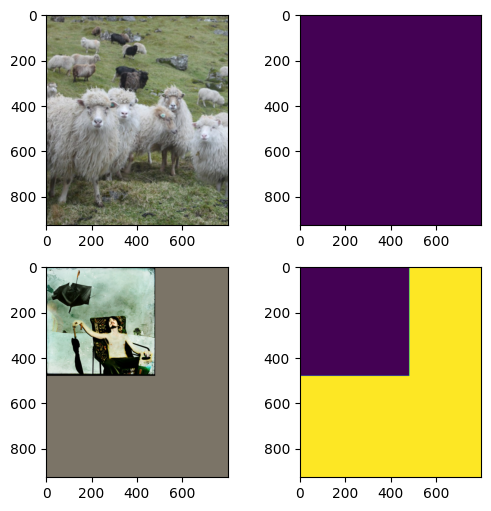

In [64]:
fig, axes = plt.subplots(figsize = (6, 3 * len(images)), nrows=tensor.shape[0], ncols=2)

for i in range(tensor.shape[0]):
    axes[i, 0].imshow(denormalize(tensor[i]))
    axes[i, 1].imshow(tensorToNumpy(mask[i]))

We'll group all these in a function

In [66]:
def collate_fn(batch):
    batch = list(zip(*batch))
    batch[0] = nested_tensor_from_tensor_list(batch[0])
    return tuple(batch)


def nested_tensor_from_tensor_list(tensor_list: List[torch.Tensor]):
    max_size = _max_by_axis([list(img.shape) for img in tensor_list])
    batch_shape = [len(tensor_list)] + max_size
    b, c, h, w = batch_shape
    dtype = tensor_list[0].dtype
    device = tensor_list[0].device
    tensor = torch.zeros(batch_shape, dtype=dtype, device=device)
    mask = torch.ones((b, h, w), dtype=torch.bool, device=device)
    for img, pad_img, m in zip(tensor_list, tensor, mask):
        pad_img[: img.shape[0], : img.shape[1], : img.shape[2]].copy_(img)
        m[: img.shape[1], :img.shape[2]] = False
    return NestedTensor(tensor, mask)

In [67]:
len(dataset)

118287

In [ ]:
data_loader_train = DataLoader(dataset_train, 
                                   collate_fn=utils.collate_fn, num_workers=args.num_workers)
data_loader_val = DataLoader(dataset_val, args.batch_size, sampler=sampler_val,
                             drop_last=False, collate_fn=utils.collate_fn, num_workers=args.num_workers)